In [2]:
# %matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, integrate

from astropy import convolution
from astropy import modeling

from lvmdrp.core.tracemask import TraceMask

In [5]:

fact = np.sqrt(2.0 * np.pi)


def fiber_profile(centroids, radii, x):
    c = np.atleast_2d(centroids).T
    r = np.atleast_2d(radii).T
    x_ = np.atleast_2d(x)
    models = 2 * np.sqrt(r**2 - (x_ - c)**2)
    models = np.nan_to_num(models, nan=0.0)

    integrals = r**2*np.arcsin(1.0)
    models = models / (2*integrals)
    return models

def gaussians(pars, x, alpha=2.3, collapse=True):
    """Gaussian models for multiple components"""
    counts, centroids, sigmas = pars
    counts = np.atleast_2d(counts).T
    centroids = np.atleast_2d(centroids).T
    sigmas = np.atleast_2d(sigmas).T
    x_ = np.atleast_2d(x)

    y = counts * np.exp(-0.5 * np.abs((x_ - centroids) / sigmas) ** alpha) / (sigmas * fact)
    if not collapse:
        return y
    return np.nansum(y, axis=0)

def oversample(x, oversampling_factor):
    dx = (x[1] - x[0]) / 2
    offsets = (np.arange(oversampling_factor) + dx) / oversampling_factor - dx
    oversampled = x[:, None] + offsets[None, :]
    return oversampled.ravel()

def pixelate(x, models, oversampling_factor):
    models_bins = models.reshape((models.shape[0], models.shape[1]//oversampling_factor, oversampling_factor))
    models_pixelated = integrate.simpson(models_bins, dx=x[1]-x[0], axis=2)
    return models_pixelated

[WARNING]: /var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_8252/1998180222.py:8: RuntimeWarning: invalid value encountered in sqrt
  models = 2 * np.sqrt(r**2 - (x_ - c)**2)



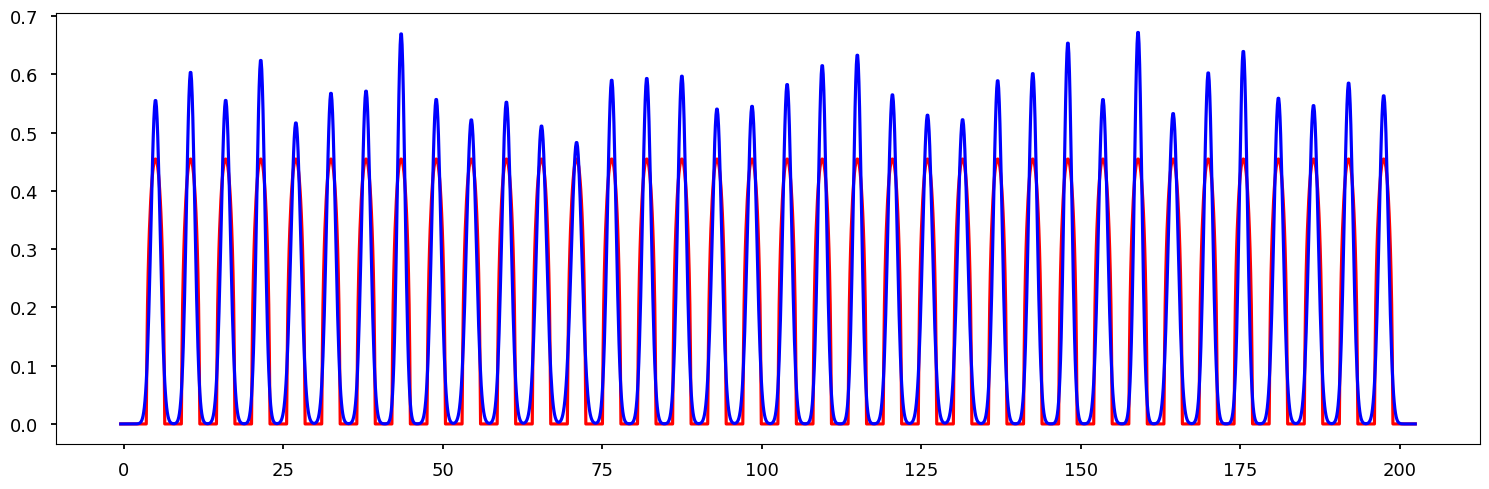

In [9]:
radius = 1.4
radii = np.ones(36) * radius
centroids = np.arange(radii.size) * 5.5 + 5
sigmas = np.ones_like(radii) * 0.7 + np.random.randn(radii.size)*0.05
counts = np.ones_like(radii)

pixels = np.arange(0, centroids.max() + 5, 1.0)
oversampling_factor = 10
x = oversample(pixels, oversampling_factor)

profiles = fiber_profile(centroids, radii, x)
psfs = gaussians((counts, centroids, sigmas), x, alpha=2.0, collapse=False)

plt.figure(figsize=(15,5), layout="tight")
plt.plot(x, np.nansum(profiles, 0), 'r-')
plt.plot(x, np.nansum(psfs, 0), 'b-')

[WARNING]: /var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_8252/1998180222.py:8: RuntimeWarning: invalid value encountered in sqrt
  models = 2 * np.sqrt(r**2 - (x_ - c)**2)



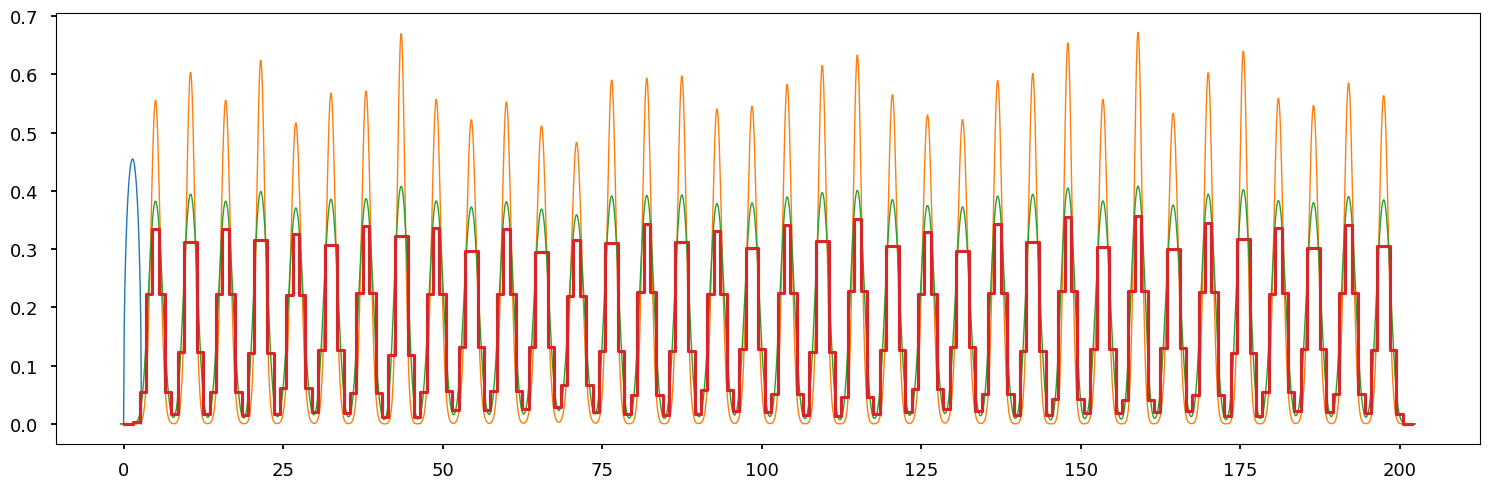

In [10]:
# %%timeit

dx = x[1]-x[0]
x_kernel = np.arange(0, 2*1.4+dx, dx)
kernel = fiber_profile(centroids=1.4, radii=1.4, x=x_kernel)
fibers_opt = signal.fftconvolve(psfs, kernel, mode="same", axes=1)
fibers_opt /= integrate.trapezoid(fibers_opt, x, axis=1)[:, None]

plt.figure(figsize=(15,5), layout="tight")
plt.plot(x_kernel, kernel.sum(0), lw=1)
plt.plot(x, psfs.sum(0), lw=1)
plt.plot(x, fibers_opt.sum(0), lw=1)
plt.step(pixels, pixelate(x, fibers_opt, oversampling_factor).sum(0), where="mid")

In [6]:
# %%timeit

dx = x[1]-x[0]
nsigmas = 6
x_kernels = [np.arange(0, 2*nsigmas*sigmas[i]+dx, dx) for i in range(centroids.size)]
kernels = [gaussians((1.0, nsigmas*sigmas[i], sigmas[i]), x_kernels[i], alpha=2, collapse=False)[0] for i in range(centroids.size)]

fibers_bru = np.asarray([signal.fftconvolve(profile, kernel, mode="same") for profile, kernel in zip(profiles, kernels)])
fibers_bru /= integrate.trapezoid(fibers_bru, x, axis=1)[:, None]

# plt.figure()
# for i in range(centroids.size):
#     plt.plot(x_kernels[i], kernels[i])
# plt.plot(x, profiles.sum(0))
# plt.plot(x, fibers_bru.sum(0))


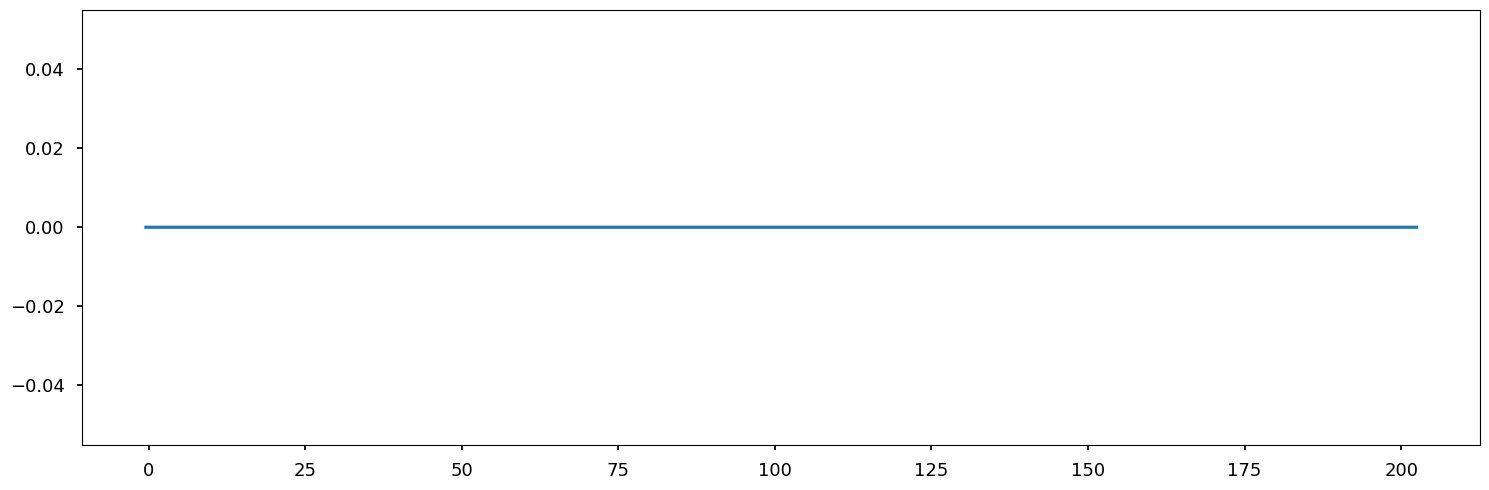

In [7]:
plt.figure(figsize=(15,5), layout="tight")
plt.plot(x, (fibers_opt - fibers_opt).sum(0))


[WARNING]: /Users/droryn/prog/lvm/lvmdrp/python/lvmdrp/core/fit_profile.py:94: RuntimeWarning: invalid value encountered in sqrt
  models = 2 * numpy.sqrt(r**2 - (x_ - c)**2)



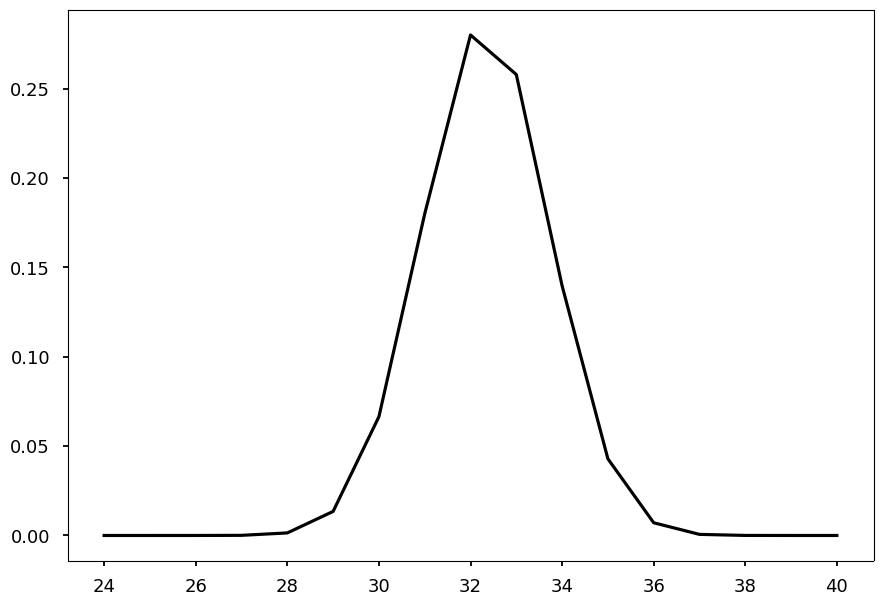

In [3]:
from lvmdrp.core import fit_profile

def _gen_mexhat_basis(x, centroids, sigmas, fiber_radius, oversampling_factor):
    dx = x[1, 0] - x[0, 0]
    x_os = fit_profile.oversample(x, oversampling_factor)
    dx_os = dx / oversampling_factor

    x_kernel = np.arange(0, 2*fiber_radius + dx_os, dx_os)
    kernel = fit_profile.fiber_profile(centroids=fiber_radius, radii=fiber_radius, x=x_kernel)
    psfs = fit_profile.gaussians((np.ones_like(centroids), centroids, sigmas), x_os.T, alpha=2, collapse=False)[0].T

    profiles = signal.fftconvolve(psfs, kernel.T, mode="same", axes=0)
    profiles /= integrate.trapezoid(profiles, x_os, axis=0)[None, :]

    # reshape model into oversampled bins: (x, oversampling_factor)
    profiles_binned = profiles.reshape((x.shape[0], oversampling_factor, x.shape[1]))
    profiles = integrate.trapezoid(profiles_binned, dx=dx_os, axis=1)
    return profiles

npixels=8
cen = np.zeros(1)+32.342
pos_t = np.trunc(cen)
sig = np.zeros(1)+1.121
yyv = np.linspace(pos_t-npixels, pos_t+npixels, 2*npixels+1, endpoint=True)
p = _gen_mexhat_basis(yyv, cen, sig, 1.4, 100)
plt.plot(yyv[:,0],p,'k-')


Fitted mu = 32.3420
Fitted sigma = 1.3342
Fitted coefficients (H3, H4, ...): [1.9168251614845264e-13, -0.00029201570308978573, -1.897726940671176e-14]


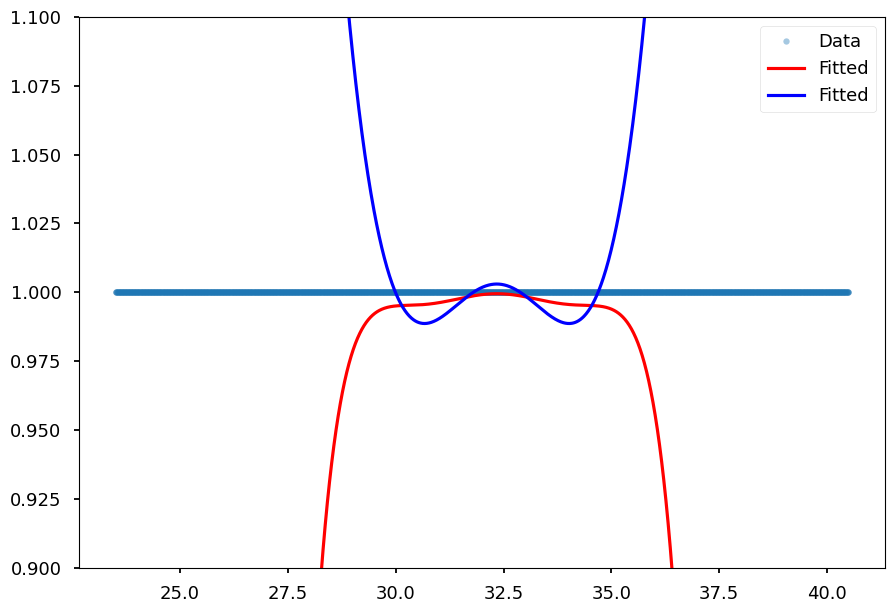

In [15]:
import numpy as np
from numpy.polynomial.hermite import Hermite
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian_hermite_model_min3(x, mu, sigma, *coeffs):
    """
    Gaussian-Hermite model with center mu, width sigma,
    and only Hermite terms of degree >= 3.
    """
    xi = (x - mu) / sigma
    fact = 1.0/(np.sqrt(2*np.pi) * sigma)
    gauss = fact * np.exp(-xi**2 / 2)
    
    start_deg = 3
    basis = [Hermite.basis(k)(xi) for k in range(start_deg, start_deg + len(coeffs))]
    return gauss * (1.0 + sum(c * b for c, b in zip(coeffs, basis)))

def fit_gaussian_hermite_varwidth_min3(x, y, degree, mu0=0.0, sigma0=1.0):
    """
    Fit Gaussian times Hermite polynomials with center & width,
    using only degrees >= 3 and constraining sigma > 0.
    
    Parameters
    ----------
    x : array_like
        Sample points.
    y : array_like
        Function values.
    degree : int
        Max Hermite polynomial degree (inclusive).
    mu0 : float
        Initial guess for Gaussian center.
    sigma0 : float
        Initial guess for Gaussian width (>0).
        
    Returns
    -------
    popt : ndarray
        Optimal parameters [mu, sigma, a3, a4, ..., a_degree].
    """
    if degree < 3:
        raise ValueError("degree must be >= 3 when starting from H3")
    
    num_coeffs = degree - 3 + 1
    p0 = [mu0, sigma0] + [0.0] * num_coeffs
    
    # Bounds: mu unbounded, sigma > 0, coefficients unbounded
    lower_bounds = [-np.inf, 1.0] + [-2e-1] * num_coeffs
    upper_bounds = [np.inf, 2.0] + [2e-1] * num_coeffs
    
    popt, pcov = curve_fit(
        lambda x, mu, sigma, *coeffs: gaussian_hermite_model_min3(x, mu, sigma, *coeffs),
        x, y, p0=p0, bounds=(lower_bounds, upper_bounds)
    )
    return popt

xx = x[:,0]
pp = p[:,0]

# Fit with degree=4 (H3 and H4 only)
popt = fit_gaussian_hermite_varwidth_min3(xx, pp, degree=5, mu0=32.3, sigma0=1.5)
fitted_mu, fitted_sigma, *fitted_coeffs = popt

print(f"Fitted mu = {fitted_mu:.4f}")
print(f"Fitted sigma = {fitted_sigma:.4f}")
print("Fitted coefficients (H3, H4, ...):", fitted_coeffs)

# Evaluate fit
y_fit = gaussian_hermite_model_min3(xx, fitted_mu, fitted_sigma, *fitted_coeffs)
y_fit2 = gaussian_hermite_model_min3(xx, fitted_mu, fitted_sigma, *[0,0,0])
#y_fit = gaussian_hermite_model_min3(xx, 32.3, 1.5, [0])

# Plot
plt.plot(xx, pp/pp, '.', alpha=0.4, label="Data")
plt.plot(xx, y_fit/pp, 'r-', label="Fitted")
plt.plot(xx, y_fit2/pp, 'b-', label="Fitted")
plt.legend()
plt.ylim(0.9,1.1)
plt.show()


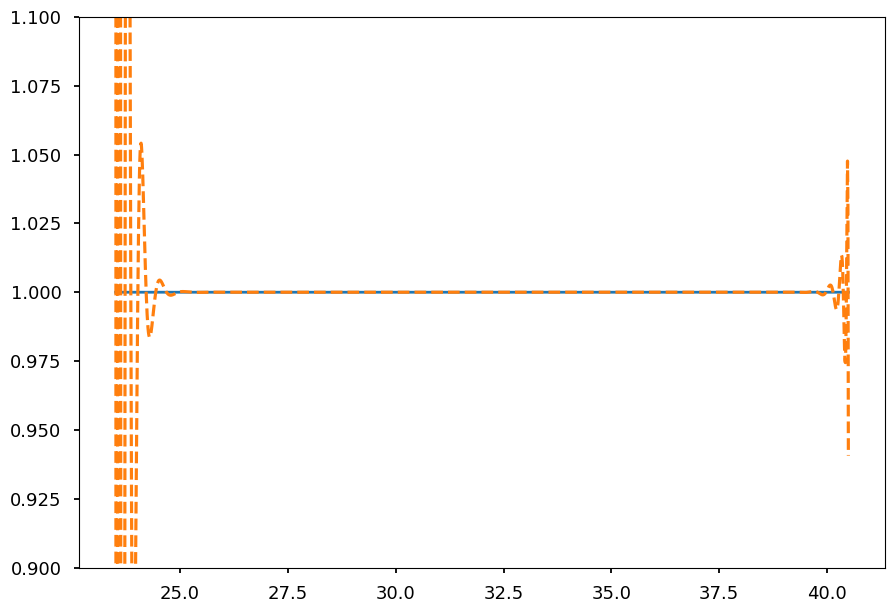

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import Chebyshev


# Fit Chebyshev polynomial to the Gaussian data
cheb_coeffs = Chebyshev.fit(xx, pp, deg=50)

# Evaluate the Chebyshev approximation
y_cheb = cheb_coeffs(xx)

# Plot the results
plt.plot(xx, pp/pp, linewidth=2)
plt.plot(xx, y_cheb/pp, linestyle='--')
plt.ylim(0.9,1.1)
plt.show()


1.9800000000000344 2.0000000000005653


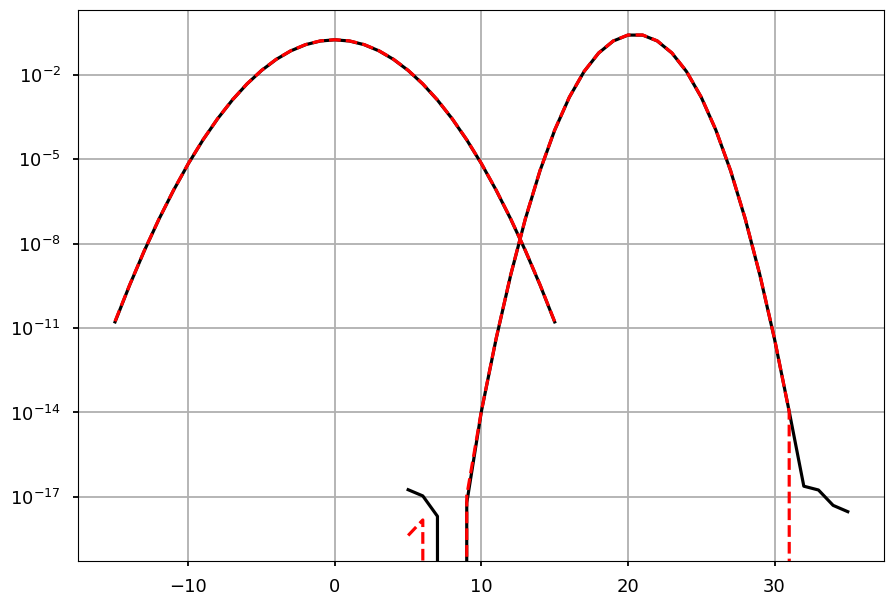

In [100]:
class FiberProfileCache(object):
    def __init__(self, fiber_radius=1.4, oversampling_factor=100, npixels=12):
        self.sigma_min = 0.5
        self.sigma_max = 2.5
        assert(fiber_radius>0)
        self.fiber_radius = fiber_radius
        assert (oversampling_factor>0)
        self.oversampling_factor = oversampling_factor
        self.nprofiles = 10000
        assert (npixels>0)
        self.npixels = npixels
        self.x = np.linspace(np.zeros(self.nprofiles)-npixels, np.zeros(self.nprofiles)+npixels, 2*npixels+1, endpoint=True)
        self.profile_cache = self._gen_mexhat_basis(self.x, np.zeros(self.nprofiles), \
                                                    np.linspace(self.sigma_min, self.sigma_max, self.nprofiles, endpoint=True), \
                                                    self.fiber_radius, self.oversampling_factor)
        self.profile_cumsum = np.cumsum(self.profile_cache, axis=0) / oversampling_factor

    def _gen_mexhat_basis(self, x, centroids, sigmas, fiber_radius, oversampling_factor):
        dx = x[1, 0] - x[0, 0]
        self.x_os = fit_profile.oversample(x, oversampling_factor)
        self.dx_os = dx / oversampling_factor

        x_kernel = np.arange(0, 2*fiber_radius + self.dx_os, self.dx_os)
        kernel = fit_profile.fiber_profile(centroids=fiber_radius, radii=fiber_radius, x=x_kernel)
        psfs = fit_profile.gaussians((np.ones_like(centroids), centroids, sigmas), self.x_os.T, alpha=2, collapse=False)[0].T

        profiles = signal.fftconvolve(psfs, kernel.T, mode="same", axes=0)
        profiles /= integrate.trapezoid(profiles, self.x_os, axis=0)[None, :]

        return profiles

    def _gen_mexhat_basis_orig(self, x, centroids, sigmas, fiber_radius, oversampling_factor):
        dx = x[1, 0] - x[0, 0]
        x_os = fit_profile.oversample(x, oversampling_factor)
        dx_os = dx / oversampling_factor

        x_kernel = np.arange(0, 2*fiber_radius + dx_os, dx_os)
        kernel = fit_profile.fiber_profile(centroids=fiber_radius, radii=fiber_radius, x=x_kernel)
        psfs = fit_profile.gaussians((np.ones_like(centroids), centroids, sigmas), x_os.T, alpha=2, collapse=False)[0].T

        profiles = signal.fftconvolve(psfs, kernel.T, mode="same", axes=0)
        profiles /= integrate.trapezoid(profiles, x_os, axis=0)[None, :]

        # reshape model into oversampled bins: (x, oversampling_factor)
        profiles_binned = profiles.reshape((x.shape[0], oversampling_factor, x.shape[1]))
        profiles = integrate.trapezoid(profiles_binned, dx=dx_os, axis=1)
        return profiles
    
    def __call__(self, centroids, sigmas):
        lines = np.clip((np.round(self.nprofiles/(self.sigma_max - self.sigma_min)*(sigmas-self.sigma_min))).astype(int), a_min=0, a_max=self.nprofiles-1)
        # return self.profile_cache[:,line]
        cumsums = self.profile_cumsum[:,lines]
        # calculate the shift relative to the given fractional centroid
        cen_fracs = centroids - np.trunc(centroids) + 0.5 # account for pixel boundaries [0...1]

        centers = self.x_os[:,lines]+cen_fracs
        bins = self.x[:,lines]
        bin_starts =  np.clip(((bins - centers[0,:]) * self.oversampling_factor).astype(int), a_min=0, a_max=None)
        bin_ends = np.clip(bin_starts + self.oversampling_factor, a_min=None, a_max=len(cumsums[:,0])-1)        
        cols = np.arange(bin_starts.shape[1])[None, :]  # shape (1, M), will broadcast to (N, M)
        return cumsums[bin_ends, cols] - cumsums[bin_starts, cols]

npixels=15
f = FiberProfileCache(1.4,100,npixels)
cen = np.array([0.0, 20.5])
pos_t = np.trunc(cen)
sig = np.array([2.1, 1.2])
yyv = np.linspace(pos_t-npixels, pos_t+npixels, 2*npixels+1, endpoint=True)
p = f._gen_mexhat_basis_orig(yyv, cen, sig, 1.4, 100)
plt.plot(yyv, p,'k-')
# %timeit F = f(cen,sig)
plt.plot(yyv, f(cen,sig), 'r--')
print(np.sum(p),np.sum(f(cen,sig)))
plt.semilogy()
plt.grid()


[ERROR]: Traceback (most recent call last):
  File "/opt/miniconda/envs/lvmdrp/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_46973/3076635558.py", line 10, in <module>
    plt.plot(f(cen,sig), 'r--')
             ^^^^^^^^^^
  File "/var/folders/31/fxk1ql6s5bx7q3kh6kwpf8v8c5vp86/T/ipykernel_46973/103356187.py", line 62, in __call__
    return cumsums[:,bin_ends] - cumsums[:,bin_starts]
           ~~~~~~~^^^^^^^^^^^^
IndexError: index 20 is out of bounds for axis 1 with size 1



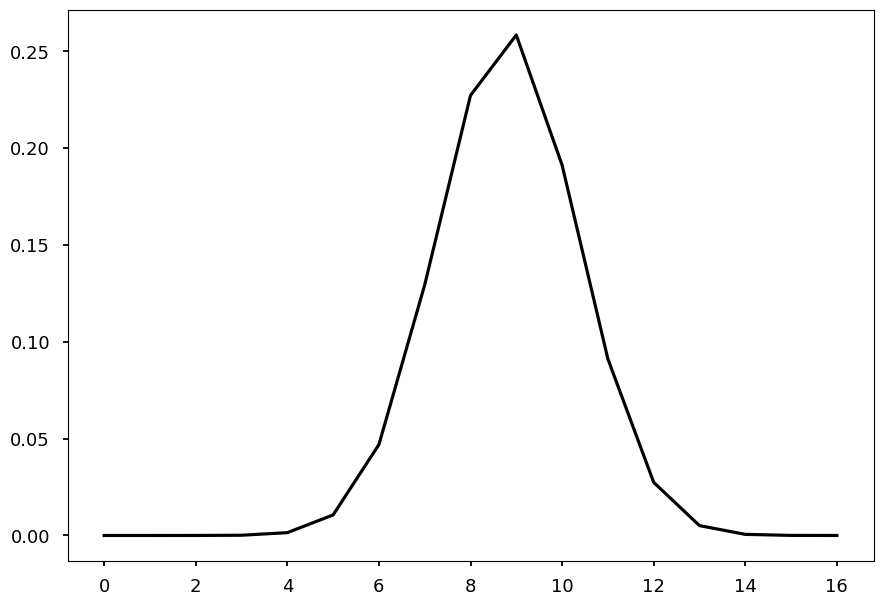